## Preprocessing the data and creating train-test datasets

This notebook is used to preprocess and concatenate data collected from several resources. We first take the 
Data from John Hopkins University and extract COVID-19 cases per state in the US. Then we add population data to each state to calculate the incident rate (number of cases oer 100'000 people). Finally we include the percentage of people staying home by using data from Safegraph. This notebook exports two different datasets. First one is the daily cases dataset which includes information per day between January-May. The second dataset is the weekly cases which aggregates the daily dataset over periods of 1 week. The weekly dataset also has additional features such as incident rate 1 week prior and change in incident rate 1 week prior. 

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import mizani
import numpy as np
plt.style.use('ggplot')

In [2]:
jhu_daily_data = "../data/daily.df"
jhu = pd.read_pickle(jhu_daily_data)

jhu['Date'] = jhu['Date'].apply(lambda x: x.to_timestamp()) 
jhu['Last_Update'] = pd.to_datetime(jhu['Last_Update'])

## Preprocessing John Hopkins University Data

* Extract Data for only US
* Fix State columns (the format of data changed from January to May)
* Combine data per state (JHU data is at county level)

In [3]:
# set the end date of the training set (start day is Jan 22nd)
# and also set the start date of the test set. Note that While preparing this notebook, the last day with info on the COVID-19 cases was May 24th
end_date_train = '2020-05-09'
start_date_test = '2020-05-10'

In [4]:
#Selecting only US Data:
jhu1 = jhu.loc[jhu['Country/Region'] == 'US']
jhu2 = jhu.loc[jhu['Country_Region'] == 'US']
jhus=[jhu1,jhu2]

jhus = pd.concat(jhus)

print(jhus.shape)

#Fill NaN values in 'Province/State' column with 'Province_State' values
jhus['Province/State'].fillna(jhus['Province_State'], inplace=True)

#Discard data about Diamond Princess and Guam (b/c no safeGraph data)
jhus=jhus[~jhus['Province/State'].str.contains('Princess')]
jhus=jhus[~jhus['Province/State'].str.contains('Guam')]
print("After dropping Guam and Diamond Princess:", jhus.shape)

states_abb = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "D.C.", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
              "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
              "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
              "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "Puerto Rico"]

states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
          "Connecticut","District of Columbia","District of Columbia","Delaware",
          "Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas",
          "Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
          "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada",
          "New Hampshire","New Jersey","New Mexico","New York","North Carolina",
          "North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island",
          "South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont",
          "Virginia","Washington","West Virginia","Wisconsin","Wyoming", "Puerto Rico"]

for i in range(len(states_abb)):
    idx = jhus['Province/State'].str.contains(states_abb[i])
    jhus.loc[idx,'Province_State'] = states[i]

for i in range(len(states)):
    idx = jhus['Province/State'].str.contains(states[i])
    jhus.loc[idx,('Province_State')] = states[i]    

#Find rows that do not contain valid State Names (e.g. Virgin Islands, American Samoa)
idx = ~jhus['Province_State'].isin(states)
jhus.loc[idx,('Province_State')] = np.NaN

#Drop remaining NaN Values in Province_State (this discards data from Virgin Islands)
jhus.dropna(subset=['Province_State'], inplace=True)
print("after dropping NaN:", jhus.shape)

jhus.head()

(185016, 18)
After dropping Guam and Diamond Princess: (184724, 18)
after dropping NaN: (184509, 18)


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date,Latitude,Longitude,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key
31,Washington,US,1/22/2020 17:00,1.0,NaN,NaN,2020-01-22,NaN,NaN,NaN,NaN,Washington,NaN,NaT,NaN,NaN,NaN,NaN
31,Washington,US,1/23/20 17:00,1.0,NaN,NaN,2020-01-23,NaN,NaN,NaN,NaN,Washington,NaN,NaT,NaN,NaN,NaN,NaN
33,Washington,US,1/24/20 17:00,1.0,NaN,NaN,2020-01-24,NaN,NaN,NaN,NaN,Washington,NaN,NaT,NaN,NaN,NaN,NaN
33,Washington,US,1/25/20 17:00,1.0,NaN,NaN,2020-01-25,NaN,NaN,NaN,NaN,Washington,NaN,NaT,NaN,NaN,NaN,NaN
34,Illinois,US,1/25/20 17:00,1.0,NaN,NaN,2020-01-25,NaN,NaN,NaN,NaN,Illinois,NaN,NaT,NaN,NaN,NaN,NaN


In [5]:
print('Total number of states:', jhus['Province_State'].nunique())

Total number of states: 52


In [6]:
# Total cases in US daily:
jhu_totals = jhus.groupby('Date').sum().reset_index()

# Daily cases per State:
jhu_state = jhus.groupby(['Date','Province_State']).sum().reset_index()

# Last reported number of cases per State:
date = jhu_state.nlargest(1,'Date')
print(date['Date'])

latest = jhu_state.loc[jhu_state['Date'] == '2020-05-24'] #change according to date as new data is downloaded
latest.head()

4301   2020-05-24
Name: Date, dtype: datetime64[ns]


,Date,Province_State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Lat,Long_,Active
4301,2020-05-24,Alabama,14478.0,551.0,0.0,0.0,0.0,161490.0,2203.246784,-5809.578199,13927.0
4302,2020-05-24,Alaska,407.0,10.0,0.0,0.0,0.0,122355.0,912.585588,-2195.321764,397.0
4303,2020-05-24,Arizona,16377.0,801.0,0.0,0.0,0.0,150212.0,505.138555,-1671.948482,15576.0
4304,2020-05-24,Arkansas,5922.0,116.0,0.0,0.0,0.0,465617.0,2584.835716,-6840.048626,5806.0
4305,2020-05-24,California,94020.0,3754.0,0.0,0.0,0.0,435321.0,2153.360119,-6881.533980,90266.0


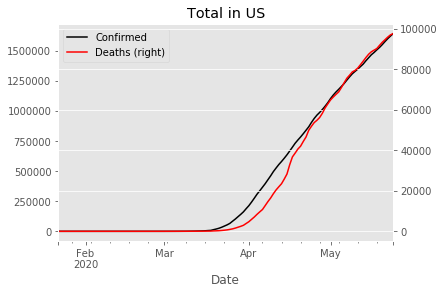

In [7]:
ax = jhu_totals.plot(x='Date',y='Confirmed',c='k',title='Total in US')
_ = jhu_totals.plot(x='Date',y='Deaths',secondary_y=True,ax=ax,c='r')

In [8]:
print(jhu_state.shape)
jhu_state.head()

#ax = jhu_state.plot(x='Date',y='Confirmed',c='k')
#_ = jhu_totals.plot(x='Date',y='Deaths',secondary_y=True,ax=ax,c='r')

(4353, 11)


,Date,Province_State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Lat,Long_,Active
0,2020-01-22,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,Illinois,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-25,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
jhu_state.tail()

,Date,Province_State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Lat,Long_,Active
4348,2020-05-24,Virginia,36244.0,1171.0,0.0,0.0,0.0,6908162.0,4996.297993,-10442.323661,35073.0
4349,2020-05-24,Washington,19828.0,1061.0,0.0,0.0,0.0,2158574.0,1842.117670,-4708.049596,18767.0
4350,2020-05-24,West Virginia,1759.0,72.0,0.0,0.0,0.0,2954961.0,2057.019673,-4272.833081,1687.0
4351,2020-05-24,Wisconsin,15277.0,510.0,0.0,0.0,0.0,4055174.0,3196.450332,-6465.454559,14767.0
4352,2020-05-24,Wyoming,838.0,12.0,0.0,0.0,0.0,1322540.0,947.158755,-2359.957083,826.0


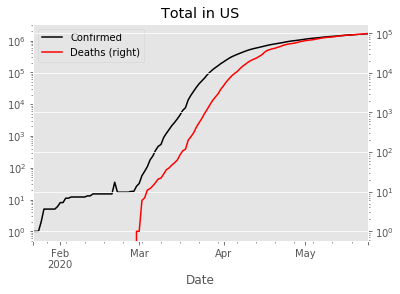

In [10]:
ax = jhu_totals.plot(x='Date',y='Confirmed',c='k',title='Total in US',logy=True)
_ = jhu_totals.plot(x='Date',y='Deaths',secondary_y=True,ax=ax,c='r',logy=True)

In [11]:
# 10 States with largest number of Confirmed cases today:
jhu_largest_state = latest.nlargest(10,'Confirmed')
print('Top 10 States with highest confirmed Cases')
jhu_largest_state

Top 10 States with highest confirmed Cases


,Date,Province_State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Lat,Long_,Active
4333,2020-05-24,New York,361515.0,29141.0,0.0,0.0,0.0,2181662.0,2474.952404,-4383.622249,332374.0
4331,2020-05-24,New Jersey,154154.0,11138.0,0.0,0.0,0.0,804475.0,846.015259,-1567.071444,143016.0
4314,2020-05-24,Illinois,110304.0,4856.0,0.0,0.0,0.0,1897267.0,4024.406089,-9005.711523,105448.0
4305,2020-05-24,California,94020.0,3754.0,0.0,0.0,0.0,435321.0,2153.360119,-6881.533980,90266.0
4322,2020-05-24,Massachusetts,92675.0,6372.0,0.0,0.0,0.0,390195.0,548.293200,-930.501649,86303.0
4339,2020-05-24,Pennsylvania,71563.0,5136.0,0.0,0.0,0.0,2908531.0,2734.811250,-5200.226295,66427.0
4345,2020-05-24,Texas,55861.0,1528.0,0.0,0.0,0.0,11042659.0,7197.086324,-22330.550323,54333.0
4323,2020-05-24,Michigan,54679.0,5228.0,0.0,0.0,0.0,2256784.0,3515.365820,-6806.532423,49451.0
4310,2020-05-24,Florida,50867.0,2237.0,0.0,0.0,0.0,898562.0,1939.030577,-5540.949842,48630.0
4321,2020-05-24,Maryland,46313.0,2277.0,0.0,0.0,0.0,667103.0,936.358097,-1840.211223,44036.0


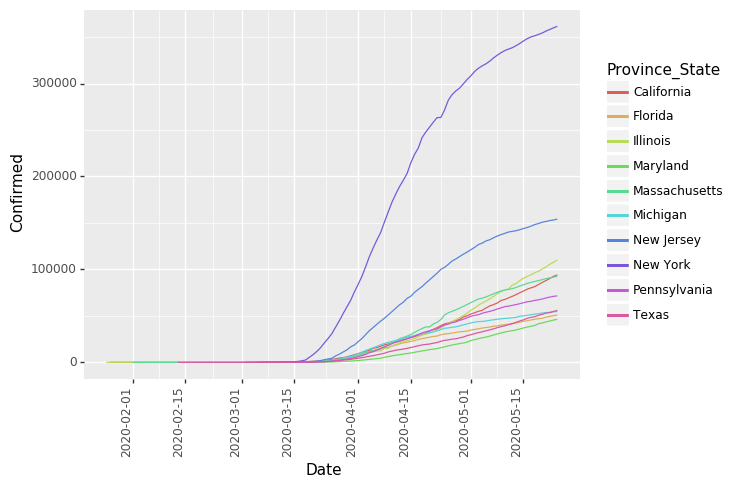

<ggplot: (-9223371880692283128)>

In [12]:
(p9.ggplot(data=jhu_state[jhu_state['Province_State'].isin(jhu_largest_state['Province_State'])],
           mapping=p9.aes(x='Date',
                          y='Confirmed',
                          color='Province_State'))
    + p9.geom_line()
    + p9.theme(axis_text_x = p9.element_text(angle = 90, hjust = 1))
)

## Adding Population Data Per State to Calculate Incident Rate

* Looking at Confirmed cases is not the best feature because population introduces bias
* We will calculate Incident Rate (number of cases per 100'000 people)

In [13]:
## Load 2019 population data from census

population = pd.read_csv('../data/population.csv')

In [14]:
population.loc[~(population['NAME'].where(population['NAME'].str.contains('Puerto'))).isnull(),'NAME']='Puerto Rico'

In [15]:
population.tail()

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2019,POPEST18PLUS2019,PCNT_POPEST18PLUS
48,40,4,9,53,Washington,7614893,5951832,78.2
49,40,3,5,54,West Virginia,1792147,1432580,79.9
50,40,2,3,55,Wisconsin,5822434,4555837,78.2
51,40,4,8,56,Wyoming,578759,445025,76.9
52,40,X,X,72,Puerto Rico,3193694,2620963,82.1


In [16]:
jhu_state['Population'] = np.zeros(len(jhu_state['Province_State']))
## Add population column per State
for j in range(len(population['NAME'])):
    for i in range(len(jhu_state['Province_State'])):
        if jhu_state.loc[i,'Province_State'] == population.loc[j,'NAME']:
            jhu_state.loc[i,'Population'] = population.loc[j,'POPESTIMATE2019']

In [17]:
## Calculate confirmed cases per 100,000 people

jhu_state['Incident_Rate'] = jhu_state['Confirmed']/jhu_state['Population']*100000

In [18]:
#jhu_state.tail()

In [19]:
## Delete unnecessary columns
jhu_state = jhu_state.drop(['FIPS','Lat','Long_','Latitude','Longitude'],axis=1)

In [21]:
latest = jhu_state.loc[jhu_state['Date'] == '2020-05-24'] #change according to date as new data is downloaded
latest.head()

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incident_Rate
4301,2020-05-24,Alabama,14478.0,551.0,0.0,13927.0,4903185.0,295.277457
4302,2020-05-24,Alaska,407.0,10.0,0.0,397.0,731545.0,55.635675
4303,2020-05-24,Arizona,16377.0,801.0,0.0,15576.0,7278717.0,224.998444
4304,2020-05-24,Arkansas,5922.0,116.0,0.0,5806.0,3017804.0,196.235408
4305,2020-05-24,California,94020.0,3754.0,0.0,90266.0,39512223.0,237.951684


In [22]:
# 10 States with highest incident rate (confirmed cases per 100,000 people):
jhu_high_incident_state = latest.nlargest(10,'Incident_Rate')

In [23]:
print('Top 10 States with highest incident rate')
jhu_high_incident_state

Top 10 States with highest incident rate


,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incident_Rate
4333,2020-05-24,New York,361515.0,29141.0,0.0,332374.0,19453561.0,1858.348711
4331,2020-05-24,New Jersey,154154.0,11138.0,0.0,143016.0,8882190.0,1735.540447
4322,2020-05-24,Massachusetts,92675.0,6372.0,0.0,86303.0,6892503.0,1344.576854
4341,2020-05-24,Rhode Island,14065.0,608.0,0.0,13457.0,1059361.0,1327.687162
4309,2020-05-24,District of Columbia,8110.0,432.0,0.0,7678.0,705749.0,1149.133757
4307,2020-05-24,Connecticut,40468.0,3693.0,0.0,36775.0,3565287.0,1135.055888
4308,2020-05-24,Delaware,8809.0,326.0,0.0,8483.0,973764.0,904.633977
4314,2020-05-24,Illinois,110304.0,4856.0,0.0,105448.0,12671821.0,870.466841
4319,2020-05-24,Louisiana,37169.0,2691.0,0.0,34478.0,4648794.0,799.540698
4321,2020-05-24,Maryland,46313.0,2277.0,0.0,44036.0,6045680.0,766.051131


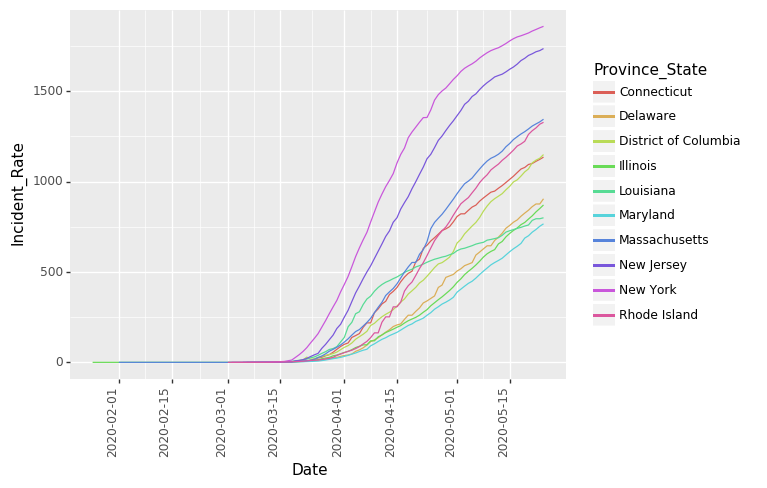

<ggplot: (-9223371880691504444)>

In [24]:
(p9.ggplot(data=jhu_state[jhu_state['Province_State'].isin(jhu_high_incident_state['Province_State'])],
           mapping=p9.aes(x='Date',
                          y='Incident_Rate',
                          color='Province_State'))
    + p9.geom_line()
    + p9.theme(axis_text_x = p9.element_text(angle = 90, hjust = 1))
)

## Calculate Number of days elapsed since Incident Rate exceeded 0.5 per State

* We will use this as a feature in our dataset, since date is an important metric in predicting the incidence rate

In [25]:
## Compute number of days elapsed since incident rate crossed threshold of 0.5

threshold = 0.5
new_data = pd.DataFrame()
States = np.unique(jhu_state['Province_State'])

for state in States:
    state_data = jhu_state.groupby(['Province_State']).get_group(state)
    cond = (state_data['Incident_Rate'] > threshold) & (state_data['Incident_Rate'].shift(1) <= threshold)
    d = state_data.loc[cond]
    thresh = d['Date'].nsmallest(1,keep='first')
    basedate = thresh
    if d.empty:
        state_data['Elapsed_Days'] = 0
    else:
        state_data['Elapsed_Days'] = np.hstack([(date - basedate).dt.days for date in state_data['Date']])
    new_data = new_data.append(state_data)
    #cross_row_inds = d[(d['Date'] >= START_TIME) & (d['Date'] <= END_TIME)].index

In [26]:
jhu_state = new_data.sort_index(0)
neg_idx = jhu_state.index[jhu_state['Elapsed_Days'] < 0]
jhu_state.loc[neg_idx,'Elapsed_Days'] = 0

In [27]:
jhu_state

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incident_Rate,Elapsed_Days
0,2020-01-22,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
1,2020-01-23,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
2,2020-01-24,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
3,2020-01-25,Illinois,1.0,0.0,0.0,0.0,12671821.0,0.007892,0
4,2020-01-25,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
...,...,...,...,...,...,...,...,...,...
4348,2020-05-24,Virginia,36244.0,1171.0,0.0,35073.0,8535519.0,424.625614,70
4349,2020-05-24,Washington,19828.0,1061.0,0.0,18767.0,7614893.0,260.384486,81
4350,2020-05-24,West Virginia,1759.0,72.0,0.0,1687.0,1792147.0,98.150431,63
4351,2020-05-24,Wisconsin,15277.0,510.0,0.0,14767.0,5822434.0,262.381677,70


## Add Shelter-in-Place Index from Safegraph

* We will use percentage of people staying home as a feature in our dataset to predict the incident rate
* The percentage staying home dataset is downloaded from Rill Data who computed the percentages from Safegraph data. This way we avoided downloading 60GB of data from Safegraph

In [28]:
## Add percentage staying home feature from Safegraph

percentage_home = pd.read_csv('../data/safegraph.csv')
date = percentage_home['__timestamp'].str.split(" ", n = 1, expand = True) 
percentage_home['Date'] = pd.to_datetime(date[0]) 
percentage_home = percentage_home.drop(columns=['__timestamp'])
percentage_home = percentage_home.rename(columns={percentage_home.columns[1]:'percentage_home'})
percentage_home

,state,percentage_home,Date
0,Puerto Rico,69.594465,2020-04-05
1,Puerto Rico,67.106363,2020-04-10
2,Puerto Rico,66.412555,2020-04-11
3,Puerto Rico,66.190164,2020-04-12
4,Puerto Rico,65.091807,2020-04-19
...,...,...,...
7535,Mississippi,15.938000,2020-01-31
7536,Mississippi,15.869747,2020-02-28
7537,Alabama,15.754319,2020-01-31
7538,Alabama,15.504751,2020-01-17


In [29]:
jhu_state['Percentage_Home'] = np.zeros(len(jhu_state))
for j in range(len(jhu_state['Province_State'])):
    cond = (jhu_state.loc[j,'Province_State'] == percentage_home['state']) & (jhu_state.loc[j,'Date'] == percentage_home['Date'])
    idx, = np.where(cond)
    if idx.shape[0] == 0: 
        jhu_state.loc[j,'Percentage_Home'] = np.nan ##Safegraph missing data for some states after 2020-05-09
    else:
        jhu_state.loc[j,'Percentage_Home'] = percentage_home.loc[idx[0],'percentage_home']

In [30]:
print(jhu_state.shape)

(4353, 10)


In [31]:
latest_safegraph = jhu_state.loc[jhu_state['Date'] == '2020-05-24'] #change according to date as new data is downloaded

# 10 States with highest shelter-in-place index (% staying home) on last updated date:
safegraph_highest_state = latest_safegraph.nlargest(10,'Percentage_Home')
print('Top 10 States with highest shelter-in-place index')
safegraph_highest_state

Top 10 States with highest shelter-in-place index


,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incident_Rate,Elapsed_Days,Percentage_Home
4340,2020-05-24,Puerto Rico,3189.0,127.0,0.0,3062.0,3193694.0,99.853023,64,57.234472
4309,2020-05-24,District of Columbia,8110.0,432.0,0.0,7678.0,705749.0,1149.133757,0,43.338653
4321,2020-05-24,Maryland,46313.0,2277.0,0.0,44036.0,6045680.0,766.051131,70,40.613616
4333,2020-05-24,New York,361515.0,29141.0,0.0,332374.0,19453561.0,1858.348711,77,40.308705
4349,2020-05-24,Washington,19828.0,1061.0,0.0,18767.0,7614893.0,260.384486,81,39.301188
4331,2020-05-24,New Jersey,154154.0,11138.0,0.0,143016.0,8882190.0,1735.540447,71,39.198605
4305,2020-05-24,California,94020.0,3754.0,0.0,90266.0,39512223.0,237.951684,73,38.894683
4306,2020-05-24,Colorado,24174.0,1332.0,0.0,22842.0,5758736.0,419.779618,74,38.506040
4322,2020-05-24,Massachusetts,92675.0,6372.0,0.0,86303.0,6892503.0,1344.576854,75,38.244637
4329,2020-05-24,Nevada,7881.0,380.0,0.0,7501.0,3080156.0,255.863664,72,37.575517


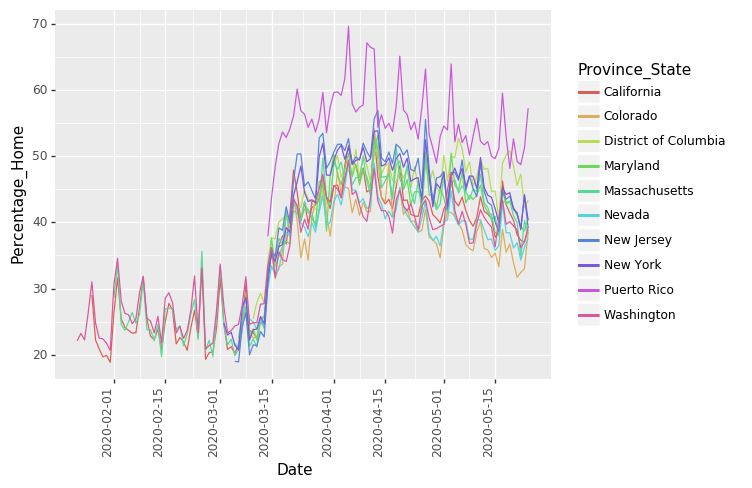

<ggplot: (-9223371880691223568)>

In [32]:
(p9.ggplot(data=jhu_state[jhu_state['Province_State'].isin(safegraph_highest_state['Province_State'])],
           mapping=p9.aes(x='Date',
                          y='Percentage_Home',
                          color='Province_State'))
    + p9.geom_line()
    + p9.theme(axis_text_x = p9.element_text(angle = 90, hjust = 1))
)

## Create Daily Training and Test Dataset

We will be using dataset from January 22 to May 9 as our training set, and data from May 10 to May 24 as our test dataset and we will try to predict top 5 States who will see the most increase in the incident rate. The data is exported to a .csv file which is then used by Models.ipynb for the regression task.

In [33]:
mask_train = (jhu_state['Date'] <= end_date_train)
mask_test = (jhu_state['Date'] >= start_date_test)

train = jhu_state.loc[mask_train]
test = jhu_state.loc[mask_test]

## Training Data
X_daily_tr = train.loc[:,['Date','Province_State','Population','Elapsed_Days','Percentage_Home']]
y_daily_tr = train.loc[:,['Date','Incident_Rate']]
                     
## Test Data 
X_daily_te = test.loc[:,['Date','Province_State','Population','Elapsed_Days','Percentage_Home']]
y_daily_te = test.loc[:,['Date','Incident_Rate']]

In [34]:
print(X_daily_tr.shape)
print(y_daily_tr.shape)
print(X_daily_te.shape)
print(y_daily_te.shape)

(3573, 5)
(3573, 2)
(780, 5)
(780, 2)


In [35]:
X_daily_tr.tail()

,Date,Province_State,Population,Elapsed_Days,Percentage_Home
3568,2020-05-09,Virginia,8535519.0,55,37.409146
3569,2020-05-09,Washington,7614893.0,66,36.911592
3570,2020-05-09,West Virginia,1792147.0,48,32.473206
3571,2020-05-09,Wisconsin,5822434.0,55,34.046194
3572,2020-05-09,Wyoming,578759.0,55,33.406820


In [36]:
X_daily_te.head() 

,Date,Province_State,Population,Elapsed_Days,Percentage_Home
3573,2020-05-10,Alabama,4903185.0,55,26.622293
3574,2020-05-10,Alaska,731545.0,53,33.555901
3575,2020-05-10,Arizona,7278717.0,52,38.224841
3576,2020-05-10,Arkansas,3017804.0,56,26.700268
3577,2020-05-10,California,39512223.0,59,40.783996


In [37]:
X_daily_tr.to_csv('../data/X_daily_tr.csv', index=False)   
y_daily_tr.to_csv('../data/y_daily_tr.csv', index=False)  
X_daily_te.to_csv('../data/X_daily_te.csv', index=False)   
y_daily_te.to_csv('../data/y_daily_te.csv', index=False)  

## Create Aggregated data over 1 week periods

We will aggregate the dataset over 1 week time periods in order to add additional features. Below, we calculate the following:
- average percentage of people staying home over a week per state
- percentage change in incident rate per week per state

We add additional features to the dataset such as:

- percentage change in incident rate last week per state
- Last reported Incident rate last week per state

We create two labels that will be used in two different regression tasks:

- Incident rate on a given date per state
- Percentage change in incident rate in a week period per state 


In [38]:
jhu_state_weekly = jhu_state
jhu_state_weekly['Date'] = jhu_state_weekly['Date'] - pd.to_timedelta(7, unit='d')
df_pct_home = jhu_state_weekly.groupby(['Province_State', pd.Grouper(key='Date', freq='W-SUN')])['Percentage_Home'].mean().reset_index().sort_values('Date')

jhu_state_weekly['Incident_rate_weekly_change_pct'] = jhu_state_weekly.groupby(['Province_State'])['Incident_Rate'].pct_change(periods=7)    
df_incident_rate_weekly_pct = jhu_state_weekly.groupby(['Province_State', pd.Grouper(key='Date', freq='W-SUN')])['Incident_rate_weekly_change_pct'].last().reset_index().sort_values('Date')

df_elapsed_days = jhu_state_weekly.groupby(['Province_State', pd.Grouper(key='Date', freq='W-SUN')])['Elapsed_Days'].last().reset_index().sort_values('Date')

df_incident_rate = jhu_state_weekly.groupby(['Province_State', pd.Grouper(key='Date', freq='W-SUN')])['Incident_Rate'].last().reset_index().sort_values('Date')

In [39]:
## Create Dataframe containing weekly data

jhu_state_weekly = pd.DataFrame()
jhu_state_weekly['Date'] = df_pct_home['Date']
jhu_state_weekly['Province_State'] = df_pct_home['Province_State']
jhu_state_weekly['Weekly_Avg_Pct_Home'] = df_pct_home['Percentage_Home']
jhu_state_weekly['Elapsed_Days'] = df_elapsed_days['Elapsed_Days']
jhu_state_weekly['Weekly_Incident_Rate_Pct_Change'] = df_incident_rate_weekly_pct['Incident_rate_weekly_change_pct']
jhu_state_weekly['Incident_Rate'] = df_incident_rate['Incident_Rate']

jhu_state_weekly['Incident_Rate_Last_week'] = jhu_state_weekly.groupby('Province_State')['Incident_Rate'].shift(1)
jhu_state_weekly['Incident_Rate_Pct_Change_Last_week'] = jhu_state_weekly.groupby('Province_State')['Weekly_Incident_Rate_Pct_Change'].shift(1)

In [40]:
jhu_state_weekly.shape

(645, 8)

In [41]:
#Drop rows with NaN resulting from shifting weekly data

jhu_state_weekly.dropna(inplace=True)
print("after dropping NaN:", jhu_state_weekly.shape)

after dropping NaN: (540, 8)


In [42]:
##replace inf with 0
jhu_state_weekly['Incident_Rate_Pct_Change_Last_week'] = jhu_state_weekly['Incident_Rate_Pct_Change_Last_week'].replace([np.inf, -np.inf], 0)

In [43]:
Cali = jhu_state_weekly['Province_State'] == "California"
cali_latest = jhu_state_weekly[Cali].nlargest(10,'Date')
print('Checking if data is aggregated correctly by looking at California')
cali_latest

Checking if data is aggregated correctly by looking at California


,Date,Province_State,Weekly_Avg_Pct_Home,Elapsed_Days,Weekly_Incident_Rate_Pct_Change,Incident_Rate,Incident_Rate_Last_week,Incident_Rate_Pct_Change_Last_week
68,2020-05-17,California,39.393190,73,0.172816,237.951684,202.889116,0.185888
67,2020-05-10,California,41.410401,66,0.185888,202.889116,171.086299,0.231262
66,2020-05-03,California,41.680220,59,0.231262,171.086299,138.951939,0.260457
65,2020-04-26,California,42.344996,52,0.260457,138.951939,110.239305,0.385829
64,2020-04-19,California,42.439308,45,0.385829,110.239305,79.547536,0.378855
63,2020-04-12,California,44.694516,38,0.378855,79.547536,57.691009,0.516230
62,2020-04-05,California,47.902782,31,0.516230,57.691009,38.048986,1.569036
61,2020-03-29,California,45.836536,24,1.569036,38.048986,14.810607,2.555286
60,2020-03-22,California,42.631691,17,2.555286,14.810607,4.165800,2.863850
59,2020-03-15,California,39.888095,10,2.863850,4.165800,1.078147,3.346939


## Create Weekly Training and Test Dataset

We are using dataset from January 22 to May 9 as our training set, and data from May 10 to May 24 as our test dataset. We have two different y labels. 'y_weekly_change' is the label that captures the weekly percentage change in incident rate per state. 'y_weekly' is the label that captures the incident rate on a certain date per state. The data is exported to a .csv file which is then used by Models.ipynb for the regression task.

In [44]:
end_date_train = '2020-05-09'
start_date_test = '2020-05-10'

mask_train = (jhu_state_weekly['Date'] <= end_date_train)
mask_test = (jhu_state_weekly['Date'] >= start_date_test)

train = jhu_state_weekly.loc[mask_train]
test = jhu_state_weekly.loc[mask_test]

## Training Data
X_weekly_tr = train.loc[:,['Date','Province_State','Weekly_Avg_Pct_Home','Elapsed_Days','Incident_Rate_Last_week','Incident_Rate_Pct_Change_Last_week']]
y_weekly_change_tr = train.loc[:,['Date','Weekly_Incident_Rate_Pct_Change']]
                     
## Test Data 
X_weekly_te = test.loc[:,['Date','Province_State','Weekly_Avg_Pct_Home','Elapsed_Days','Incident_Rate_Last_week','Incident_Rate_Pct_Change_Last_week']]
y_weekly_change_te = test.loc[:,['Date','Weekly_Incident_Rate_Pct_Change']]

In [45]:
print(X_weekly_tr.shape)
print(y_weekly_change_tr.shape)
print(X_weekly_te.shape)
print(y_weekly_change_te.shape)

(436, 6)
(436, 2)
(104, 6)
(104, 2)


In [46]:
X_weekly_tr.tail()

,Date,Province_State,Weekly_Avg_Pct_Home,Elapsed_Days,Incident_Rate_Last_week,Incident_Rate_Pct_Change_Last_week
247,2020-05-03,Maine,36.067237,56,88.155737,0.167488
439,2020-05-03,Ohio,36.131360,54,170.363843,0.246807
90,2020-05-03,Connecticut,42.320892,57,821.448596,0.159009
66,2020-05-03,California,41.680220,59,138.951939,0.260457
487,2020-05-03,Puerto Rico,53.003653,50,56.611560,0.318745


In [47]:
X_weekly_te.head() 

,Date,Province_State,Weekly_Avg_Pct_Home,Elapsed_Days,Incident_Rate_Last_week,Incident_Rate_Pct_Change_Last_week
202,2020-05-10,Iowa,31.539752,66,379.040719,0.303433
214,2020-05-10,Kansas,32.615333,61,238.594261,0.348138
587,2020-05-10,Virginia,36.710360,63,282.126957,0.289685
248,2020-05-10,Maine,32.945204,63,106.828387,0.211814
575,2020-05-10,Vermont,35.443056,64,148.560311,0.033445


In [48]:
X_weekly_tr.to_csv('../data/X_weekly_tr.csv', index=False)   
y_weekly_change_tr.to_csv('../data/y_weekly_change_tr.csv', index=False) 
X_weekly_te.to_csv('../data/X_weekly_te.csv', index=False)   
y_weekly_change_te.to_csv('../data/y_weekly_change_te.csv', index=False)  